# Data Extraction from StatsBomb

Geeting public information from Stats Bomb using public API

The main idea is to request information from the API and then get the information in the way is need so we can create a functional Power BI Dashboard with main charts to analize the game selected.

## Libraries needed
First, we import all the libraries we are going to use. (We have to be sure that all the packages and dependecies are installed).

The libraris used on this project are:
- **statsbombpy:** this is the main library. This is the python library provided by Stats Bomb to import games information from their database. You can read more about it here: https://github.com/statsbomb/statsbombpy

- **pandas:** popular library for dataframe manipulation
- **mplsoccer:** this library include functions and method to generate soccer related visuals so we can present football soccer analysis. For instance, we can generate a soccer field with the measures we want and add visuals for passes directions, hearmaps, percentage of ball possesion per area in the pitch, etc. You can read more about it here: https://mplsoccer.readthedocs.io/en/latest/
- **highlight_text:** this package help us to create easy anotations in matplolib. You can read more about ir here: https://pypi.org/project/highlight-text/
- **matplotlob.colors & matplotlib.pyplot:** helps us to create statistical charts with python.
- **openpyxl:** help us to manipulate excel files. This is useful when we want to export (for example) the information to an Excel file. Also could help us to manipulates rows and colums inside the Excel file, just like we could do with a macro using VBA.

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.pyplot as plt
import openpyxl

### Geeting competion matches

The first step is get the information we need. As the way of statsbomb information is designed, we need to provide the competition id and the season id (Basically the competion's year)

We are getting the games from the FIFA World Cup 2022 as follows

In [2]:
competion_id = 43 #Fifa World Cup
season_id = 106   #Year 2022

matches_data = sb.matches(competition_id=competion_id, season_id=season_id)
matches_data.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

Notice that the marches_data dataframe now contains the matches' information for the competition and season we need. The output of the **matches_date.columns** command is the list of columns available.

Let's analyse one game, the great final of the tourtnament! Argentina vs France

What we are going to do is to get the Argentina games (we could us France's games too) and save the result in a dataframe named **argentina_matches**. Then we sout the result by the match week. This way we can see Argentina' progression during the tourtnament.

In [3]:
#Checking all Argentina games
argentina_matches = matches_data[(matches_data["home_team"] == "Argentina") | (matches_data["away_team"] == "Argentina")]
argentina_matches.sort_values(by="match_week")

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
37,3857300,2022-11-22,12:00:00.000,International - FIFA World Cup,2022,Argentina,Saudi Arabia,1,2,available,...,2023-06-19T15:59:46.628887,1,Group Stage,Lusail Stadium,Slavko Vinčić,Lionel Sebastián Scaloni,Hervé Renard,1.1.0,2,2
13,3857289,2022-11-26,21:00:00.000,International - FIFA World Cup,2022,Argentina,Mexico,2,0,available,...,2023-06-20T11:57:08.547882,2,Group Stage,Lusail Stadium,Daniele Orsato,Lionel Sebastián Scaloni,Gerardo Daniel Martino,1.1.0,2,2
11,3857264,2022-11-30,21:00:00.000,International - FIFA World Cup,2022,Poland,Argentina,0,2,available,...,2023-07-25T09:10:13.832053,3,Group Stage,Stadium 974,Danny Desmond Makkelie,Czesław Michniewicz,Lionel Sebastián Scaloni,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
6,3869321,2022-12-09,21:00:00.000,International - FIFA World Cup,2022,Netherlands,Argentina,2,2,available,...,2023-06-21T17:51:12.511460,5,Quarter-finals,Lusail Stadium,Antonio Miguel Mateu Lahoz,Louis van Gaal,Lionel Sebastián Scaloni,1.1.0,2,2
19,3869519,2022-12-13,21:00:00.000,International - FIFA World Cup,2022,Argentina,Croatia,3,0,available,...,2023-04-26T22:32:37.808359,6,Semi-finals,Lusail Stadium,Daniele Orsato,Lionel Sebastián Scaloni,Zlatko Dalić,1.1.0,2,2
9,3869685,2022-12-18,17:00:00.000,International - FIFA World Cup,2022,Argentina,France,3,3,available,...,2023-08-17T15:55:15.164685,7,Final,Lusail Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Didier Deschamps,1.1.0,2,2


The match ID of the Final game is 3869685. Let's get all the information about that game. With sv.events() method, we can extract all the events of the game. Cool right?!

In [4]:
final_events = sb.events(match_id=3869685)

#We filter the events by type "Pass"
filter_pass_events = final_events[(final_events['type'] == 'Pass')]

#Columns selection (we don't need all of them)
pass_events = filter_pass_events[['id', 'timestamp','minute', 'second', 'team_id', 'team', 'location', 'pass_type', 'pass_outcome', 'player_id', 'player', 'pass_end_location']]

#Then we reset the index
pass_events = pass_events.reset_index(drop=True)

#And get the start and end location of the passes
pass_events[['x', 'y']] = pd.DataFrame(pass_events['location'].tolist(), index=pass_events.index)
pass_events[['endx', 'endy']] = pd.DataFrame(pass_events['pass_end_location'].tolist(), index=pass_events.index)

#Inside df we save the passes information or one team. In this case, the ID 779 corresponse to Argentina
df = pass_events[pass_events['team_id'] == 779]

#We fill the N/A values in the column "pass_outcome" with the text "Successful"
#In Statsbomb, the N/A in this field represent a completed pass
df.loc[:, 'pass_outcome'] = df['pass_outcome'].fillna('Successful')
df = df[df['pass_outcome'] == 'Successful']
df = df.reset_index(drop=True)
df.head(10)

,id,timestamp,minute,second,team_id,team,location,pass_type,pass_outcome,player_id,player,pass_end_location,x,y,endx,endy
0,5ba6dfab-49f0-4225-bbb6-8b1e27bc729a,00:00:16.423,0,16,779,Argentina,"[22.7, 80.0]",Throw-in,Successful,29201.0,Nahuel Molina Lucero,"[36.0, 75.2]",22.7,80.0,36.0,75.2
1,27829865-a43c-4c50-b545-b09e8a965e16,00:00:31.843,0,31,779,Argentina,"[41.1, 73.9]",Free Kick,Successful,7797.0,Rodrigo Javier De Paul,"[23.2, 62.8]",41.1,73.9,23.2,62.8
2,59420b0c-94cc-4fb8-86fb-e1105936f6eb,00:00:34.727,0,34,779,Argentina,"[24.7, 59.4]",NaN,Successful,20572.0,Cristian Gabriel Romero,"[21.5, 32.2]",24.7,59.4,21.5,32.2
3,71cb648d-11fe-4275-b838-cbcfc62bee04,00:00:39.227,0,39,779,Argentina,"[24.0, 27.1]",NaN,Successful,3090.0,Nicolás Hernán Otamendi,"[21.7, 49.3]",24.0,27.1,21.7,49.3
4,4fd86774-8f37-4ea2-b562-b1a43c5adedf,00:00:43.285,0,43,779,Argentina,"[22.1, 49.8]",NaN,Successful,20572.0,Cristian Gabriel Romero,"[24.0, 27.3]",22.1,49.8,24.0,27.3
5,4a4fd288-9139-4987-9c2a-3ab0e1793310,00:00:45.601,0,45,779,Argentina,"[21.7, 24.5]",NaN,Successful,3090.0,Nicolás Hernán Otamendi,"[26.6, 3.1]",21.7,24.5,26.6,3.1
6,bdf6b02c-1c04-4777-9617-bf73ececbf6c,00:00:47.599,0,47,779,Argentina,"[29.2, 2.5]",NaN,Successful,5507.0,Nicolás Alejandro Tagliafico,"[45.6, 4.2]",29.2,2.5,45.6,4.2
7,03ffd8af-1f1f-42b4-9c25-37d2a0c07981,00:01:01.290,1,1,779,Argentina,"[44.1, 3.8]",Free Kick,Successful,5507.0,Nicolás Alejandro Tagliafico,"[20.8, 11.9]",44.1,3.8,20.8,11.9
8,03684593-83f8-4faa-9039-721b694edad8,00:01:04.704,1,4,779,Argentina,"[21.7, 17.7]",NaN,Successful,3090.0,Nicolás Hernán Otamendi,"[19.7, 33.3]",21.7,17.7,19.7,33.3
9,b90345b4-bb59-44ab-a670-08eb54053252,00:01:12.037,1,12,779,Argentina,"[30.9, 42.5]",NaN,Successful,20572.0,Cristian Gabriel Romero,"[27.9, 22.6]",30.9,42.5,27.9,22.6


If we take a depper look into our data, we will notice that we don't have the player jersey number, just the id, and if we want to create a passes map, we need the actual numbers of the player's in the field. 

Luckly that's available in the column tactics, under the type "Starting XI" and as a Json string, just like this:
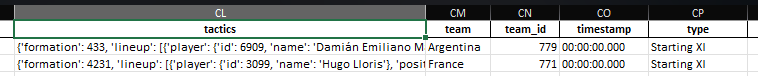

So firts, before to continue, we must get the jersey numbers from these fields so we can join that to our dataframe (df)

In [5]:
#First, we get those column in a separate dataframe from the original one
df_startingXI = final_events[final_events['type'] == "Starting XI"].reset_index(drop=False)
df_startingXI = df_startingXI[['team_id','tactics']]
df_startingXI

#Now that we have the starting XI, we procede to create another dataframe but this time with a table version of the json string
players_data = []

# We stepping the dataframe df_startingXI to extract the info we need 
for _, row in df_startingXI.iterrows():
    # Extraer el 'lineup' de la columna 'tactics'
    lineup = row['tactics']['lineup']
    for player in lineup:
        players_data.append({
            'match_id': row['team_id'],  # ID del partido
            'player_id': player['player']['id'],
            'player_name': player['player']['name'],
            'jersey_number': player['jersey_number']
        })

# Then we convert the values to a dataframe
df_players = pd.DataFrame(players_data)
df_players


,match_id,player_id,player_name,jersey_number
0,779,6909,Damián Emiliano Martínez,23
1,779,29201,Nahuel Molina Lucero,26
2,779,20572,Cristian Gabriel Romero,13
3,779,3090,Nicolás Hernán Otamendi,19
4,779,5507,Nicolás Alejandro Tagliafico,3
5,779,38718,Enzo Fernandez,24
6,779,7797,Rodrigo Javier De Paul,7
7,779,27886,Alexis Mac Allister,20
8,779,5503,Lionel Andrés Messi Cuccittini,10
9,779,2995,Ángel Fabián Di María Hernández,11


Now that we have this dataframe with the jersey's number of the players, we can process with the merge of this information with passes event dataframe (df)

In [6]:
# So we merge both dataframes to include the player's jersey number in df_passes
df_passes = df.merge(df_players[['player_id', 'jersey_number']], on='player_id', how='left')

# Then we filter the null values of jerseys (because we are not going to include sustitutions)
df_passes = df_passes[df_passes['jersey_number'].notnull()]

# Then we two columns for the passer and the recipient of the pases
df_passes['passer'] = df_passes['jersey_number']
df_passes['recipient'] = df_passes['jersey_number'].shift(-1)

df_passes['passer'] = pd.to_numeric(df_passes['passer'], downcast='integer')
# Converf to number (NaN for errors)
df_passes['recipient'] = pd.to_numeric(df_passes['recipient'], errors='coerce')

# Replace NaN values with zero (0) and convert to integer
df_passes['recipient'] = df_passes['recipient'].fillna(0).astype(int)

df_passes.head(3)

,id,timestamp,minute,second,team_id,team,location,pass_type,pass_outcome,player_id,player,pass_end_location,x,y,endx,endy,jersey_number,passer,recipient
0,5ba6dfab-49f0-4225-bbb6-8b1e27bc729a,00:00:16.423,0,16,779,Argentina,"[22.7, 80.0]",Throw-in,Successful,29201.0,Nahuel Molina Lucero,"[36.0, 75.2]",22.7,80.0,36.0,75.2,26.0,26,7
1,27829865-a43c-4c50-b545-b09e8a965e16,00:00:31.843,0,31,779,Argentina,"[41.1, 73.9]",Free Kick,Successful,7797.0,Rodrigo Javier De Paul,"[23.2, 62.8]",41.1,73.9,23.2,62.8,7.0,7,13
2,59420b0c-94cc-4fb8-86fb-e1105936f6eb,00:00:34.727,0,34,779,Argentina,"[24.7, 59.4]",NaN,Successful,20572.0,Cristian Gabriel Romero,"[21.5, 32.2]",24.7,59.4,21.5,32.2,13.0,13,19


### Geeting the passes' count

Now we have the df_passes ready, we can move to the next step: getting the number of passes per players and direction.

In [7]:
# First, we need to calculate the average position of every player passes in the field
avg_locations = df_passes.groupby('passer').agg({'x': ['mean'], 'y':['mean', 'count']})
avg_locations.columns = ['x', 'y', 'loc_passes']
avg_locations

# Then we need to find the number of passes between players
pass_between = df_passes.groupby(['passer', 'recipient']).id.count().reset_index()
pass_between
pass_between.rename({'id':'passes'}, axis='columns', inplace=True)
pass_between = pass_between.merge(avg_locations, left_on='passer', right_index=True)
pass_between = pass_between.merge(avg_locations, left_on='recipient', right_index=True, suffixes=['', '_end'])
pass_between

pass_between = pass_between[pass_between['passes'] > 3]
pass_between
avg_locations

,x,y,loc_passes
passer,,,
3,58.972727,7.643182,44
7,57.138596,58.984211,57
9,77.707692,34.746154,26
10,76.457143,49.675510,49
11,79.884000,11.448000,25
13,33.871667,52.686667,60
19,38.540580,24.650725,69
20,68.148889,26.637778,45
23,11.433333,42.155556,18


Let's add some style to the chart we will create later

In [ ]:
# First let's add markets sizes related to the passes
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
pass_between['width'] = (pass_between['passes'] / pass_between['passes'].max() *
                           MAX_LINE_WIDTH)
avg_locations['marker_size'] = (avg_locations['loc_passes']
                                         / avg_locations['loc_passes'].max() * MAX_MARKER_SIZE)

# Now let's add some transparency based on the number of pases between players
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between['passes'] / pass_between['passes'].max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency



Now what we want to do is to create the pitch where we are going to map the pases. Using mplsoccer library, we can achieve that. All the documentation is available here: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_pass_network.html

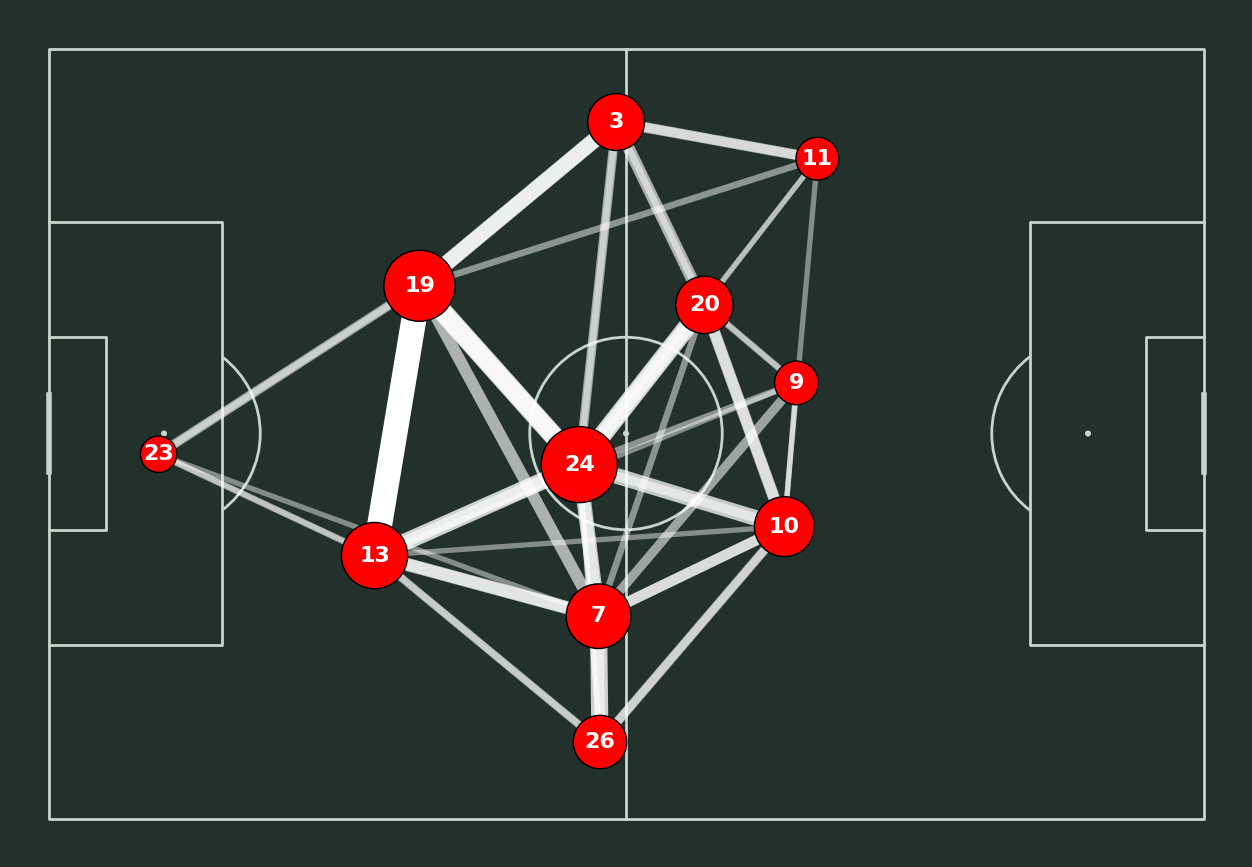

In [12]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")
pass_lines = pitch.lines(
    pass_between.x, 
    pass_between.y,
    pass_between.x_end, 
    pass_between.y_end, 
    lw=pass_between.width,
    color=color, zorder=1, ax=ax)
pass_nodes = pitch.scatter(avg_locations.x, avg_locations.y,
                           s=avg_locations.marker_size,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)
for index, row in avg_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)
